## $\Sigma-\Delta$-modulator phase noise in fractional-N PLL's

## Library imports

In [1]:
# Array fast operation
from __future__ import division
import numpy as np
from numpy import (ones, pi, log10)

# Signal processing routines
import scipy.signal as sig

# Plotting 
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
mpl.style.use('ggplot')
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.figsize']  = (9,6)
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.grid'] = True

# Load the modules for pnoise manimulation and SDM modules
import plldesigner.pnoise as pn
import plldesigner.sdmod as sdmod

## Introduction

The first time that I needed to design a fractional-N PLL if took me  quite some time to gain confidence over the model I was using to calculate the phase noise produced by the $\Sigma\Delta$-modulators(SDM). The reason for that  is that there are a couple of mathematical pitfalls that are difficult to avoid at first. Many times I tough that a reference code would have made my life much simpler. This is one of those topics where a notebook including both theory and code seems particular appealing. 

This entry expose first the SDM theory in the first section, the second section shows how a mash SDM works and explain the model in Python and the last section show the results and the comparison with the theoretical model.  The SDM model is part of a more general package to design PLL's that is available in github.

## Linear phase noise analysis for the excess of phase noise at the output of a fractional divider using a $\Sigma-\Delta$ modulator 

The circuit in figure 1 implements the fractional division of input $f_{in}$  by the fractional
period defined by $N+f(z)$ using a SDM. As it is difficult to design a reliable circuit that divides a input frequency by a fractional number a integer divider with a division factor that is in average the desired value is used. This operation introduces unwanted phase changes in the output signal and we are interested the power spectral density of these disturbances.
<br>
<img src="images/fractional_divider.png" alt="Fractional divider" height=400px/>
<center> Figure 1. Topology of a fractional divider made with a SDM </center>
<br>


The instantaneous frequency division of the divider in the figure is given by:


$$\begin{equation}
    N_{div}(z) = N+f(z)+H_{s}(z) \Delta_{q}(z),
\end{equation}$$

Where $N$ is that integer part of the division ratio, $f(z)$ is the fractional part, and 
$H_s(z) \Delta_{q}(z)$ is the instantaneous error made by a SDM of order m. The instantaneous noise of the SDM has two components $\Delta_{q}(z)$ is the quantization noise and $H_s(z)$ is the noise shaping transfer function of the SD modulator.  

The output frequency of the SD modulator is given by: 

$$\begin{equation}
    f_{div}(z) = \frac{f_{in}}{N+f(z)+H_s(z) \Delta_{q}(z)},
\end{equation}$$

that can be simplified, using the approximation $\frac{1}{1+x} \approx  1-x \: \text{for } x << 1$, as:

$$\begin{equation}
    f_{div}(z) = \frac{f_{in}}{N+f(z)}\left(1 - \frac{H_s(z) \Delta_{q}(z)}{N+f(z)}\right),
\end{equation}$$

As $\frac{f_{in}}{N+f(z)}$ equals the target frequency, which in a PLL is the reference frequency   $f_{ref}$, the frequency error as a function of the target frequency equals:

$$\begin{equation}
    \Delta_{f_{div}}(z) = - f_{ref} \frac{ H_s(z) \Delta_{q}(z)}{N+f(z)}.
\end{equation}$$

The power spectral density of the quantization noise can be approximated using a similar assumption than the one used to calculate the spectrum of the quantization noise of a ADC. With a minimun steps size $\delta$ equals two one the power of the errro can be approximated by:

$$\begin{equation}
    \Delta_{q}^2 = \frac{1}{12} (step^2),
\end{equation}$$

this noise is uniformly distributed over the Nyquist bandwidth of the sampler, than in the case of a PLL is $f_{ref}/2$, and it has a power spectral density given by:

$$\begin{equation}
    \Delta_{q}^2 = \frac{1}{6 f_{ref}} (step^2/Hz). 
\end{equation}$$

The other aspect that needs to be accounted for, in order to find a close expression for the phase noise, is the shaping of the SDM, for Mash-1-1-1 SDM this is given by[1]:

$$\begin{equation}
    H_s(z)= (1-z^{-1})^m, 
\end{equation}$$

where m is the SDM order. 

With this elements in place it is possible to have a better expression for the error made approximating the frequency, thus:

$$\begin{equation}
    \Delta_{f_{div}}(z)^2 =  \left|f_{ref} \frac{ (1-z^{-1})^m}{N+f(z)}\right|^2 \frac{1}{6 f_{ref}}.
\end{equation}$$

As it happens we are interesting in the phase, and this is calculated by integrating the last expression in the z-domain. Then we have: 

$$\begin{equation}
\Phi_{div}(z) = \frac{2 \pi T_{ref} \Delta_{f_{div}}(z)}{1-z^{-1}},
\end{equation}$$

that putting everything together ends being:
    
$$\begin{equation}
\Phi_{div}(z)^2 = \frac{(2 \pi)^2}{6 f_{ref}} \frac{|1-z^{-1}|^{2(m-1)}}{(N+f(z))^2}(Rad^2/Hz)
\end{equation}$$


by definition $\mathcal{L}(z)= \Phi_{div}(z)^2/2$, then: 

$$\begin{equation}
	\mathcal{L}(z) = \frac{(2 \pi)^2}{12 f_{ref}} \frac{|1-z^{-1}|^{2(m-1)}}{(N+f(z))^2}(Rad^2/Hz),
\end{equation}$$

that can be replaced by a more useful expression where $z$ is replaced by $e^{sT_{ref}}$. Calling the frequency offset $f_m$, to emphasis that this is the frequency offset due to modulation, the result is:

$$\begin{equation}
  \mathcal{L}(f_m) = \frac{(2 \pi)^2}{12 f_{ref}} \frac{[2 sin(\pi f_m/ f_{ref})]^{2(m-1)}}{(N+f(z))^2}.
\end{equation}$$

As presented here this is the noise at the output of the divider, normally in previous references, [1] and [2], the noise is calculated at the input of the divider, but I consider this clearer. If the equivalent noise at the input of the divider needs to be calculated that can be done by simply multipling the last equation by $(N+f(z))^2$.

## Using the pnoise module and the sdmod to simulate a SDM

Within the [plldesigner](https://github.com/jfosorio/plldesigner) project two modules implement a class for adding pnoise frequency domain signals and creating SDM sequences.

The sigma delta modulator is implemented by an algorithm that uses a counter that add every time the input word K and overflows when the value reaches MAX. MAX is the maximum value of the SDM register, that is: $2^N-1$, for a register of N bits. The next code shows how a first order modulator is implemented:

```python
k = round(Nfloat*2**N)
for j in arange(0, L):
    state = state + k[j - 1]
    if state > _maxvalue:
        over = 1
        state -= _maxvalue + 1
    else:
        over = 0
        sd[j] = over
```

The implementation of first, second and third order Sigma-delta modulators can be found in: [plldesigner](https://github.com/jfosorio/plldesigner)

### Creating a SDM sequence with the sdmod module

In order to create a 1-1-1 Mash sequence the gen_mash function was created in the sdmod module. The function has as inputs, the order of the modulator m, number of bits of the accumulator and the
input vector $k[n]$. The following code shows the sequence created by a SDM of third order.

Mean value of the sequence: 0.253220



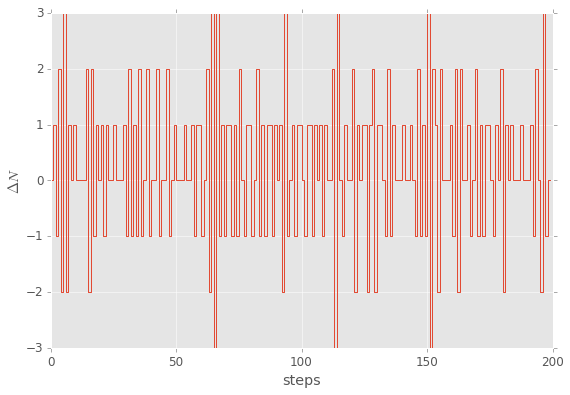

In [2]:
# Parameters 
NsdBits = 19
fref = 27.6e6
Tref = 1.0/fref

# Create a SDM sequency 
fracnum = ((0.253232*2**NsdBits)*ones(100000)).astype(int)
sd, per = sdmod.gen_mash(3,NsdBits,fracnum)
plt.step(np.r_[0:200],sd[:200]);
plt.xlabel('steps') #x label
plt.ylabel('$\Delta N$') #y label
print("Mean value of the sequence: {:2.6f}\n".format(sd.mean()))

The phase error $\phi_{out}[n]$ can be calculated integrating the error in the frequency. Then the power spectrum density is estimated with the [welch periodogram](http://docs.scipy.org/doc/scipy-dev/reference/generated/scipy.signal.welch.html).


Integrated phase noise
Theory: 4.443 (rad,rms)
Sim   : 4.427 (rad,rms)


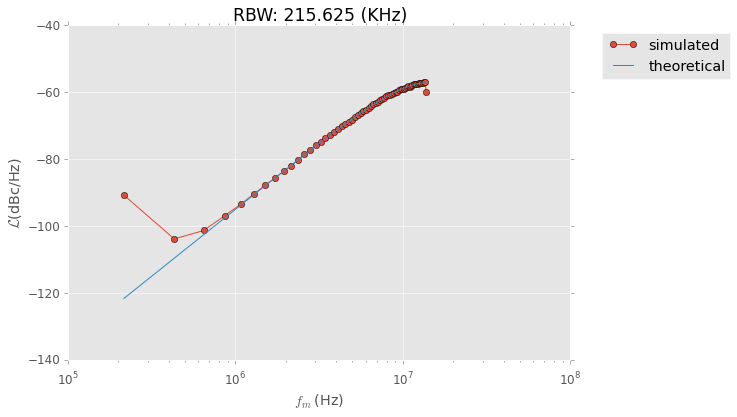

In [3]:
# Phi_er at the output equals \sum{\DeltaN*fref}*Tref
phi_div = 2*pi*(sd-fracnum[0]/2**NsdBits).cumsum()

# Calculate the spectrum
npoints = 2**7
f, Phi2_div = sig.welch(phi_div, fref, window='blackman', nperseg=npoints)
rbw = fref/2/(len(f)-1)
ind = (f>1e5) & (f<1e9)
sim = pn.Pnoise(f[ind],10*log10(Phi2_div[ind]/2), label='simulated')

# calcualte the L teorical
theory = sdmod.L_mash_dB(3,fref)
theory.fm = f[ind]
theory.label = 'theoretical'

# Calculate the integral value of the two
print('''
Integrated phase noise
======================
Theory: {:2.3f} (rad,rms)
Sim   : {:2.3f} (rad,rms)'''.format(theory.integrate(),sim.integrate()))

# plot both the spectrums
sim.plot('o-')
ax = theory.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.title('RBW: {:2.3f} (KHz)'.format(rbw/1e3))
val = plt.ylim([-140,-40])

## Non-linear behavior of the $\Sigma-\Delta$ modulator

The previous theory fails to predict spurs that can occur when the input is a rational number.  This is demonstrated using the same SDM but with a input equivalent to 1/8. It is important to understand these spurs as they can fall in band after they are folded back by the non-linearity of the CP and the PFD.

Mean value of the sequence: 0.24999



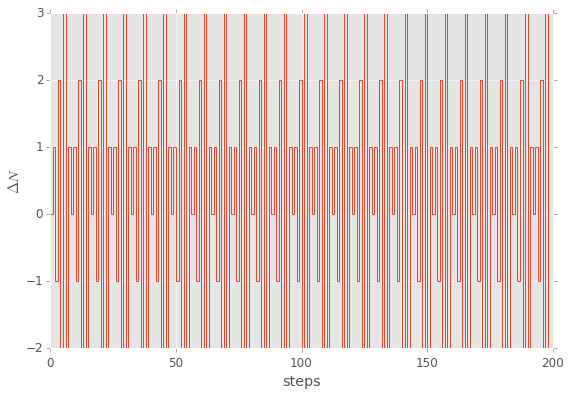

In [4]:
# Fraction number
fracnum = (2/8*2**NsdBits)*ones(100000)

# Produce the SDM sequence
sd, per = sdmod.gen_mash(3,NsdBits,fracnum)

# Calculate the phase error and its PSD
phi_div = 2*pi*(sd-fracnum[0]/2**NsdBits).cumsum()
f, Phi2_div = sig.welch(phi_div, fref, window="blackman", nperseg=npoints)
sim = pn.Pnoise(f[ind],10*log10(Phi2_div[ind]/2), label='simulated')

# plot the sequence
plt.step(np.r_[0:200],sd[:200])
plt.xlabel('steps') #x label
plt.ylabel('$\Delta N$') #y label

print("Mean value of the sequence: {:2.5f}\n".format(sd.mean()))

In [5]:
sd, per = sdmod.gen_mash(3,NsdBits,fracnum)
sd[:100]

array([ 0,  0,  1, -1,  2, -2,  3, -2,  1,  0,  1, -1,  2, -2,  3, -2,  1,
        0,  1, -1,  2, -2,  3, -2,  1,  0,  1, -1,  2, -2,  3, -2,  1,  0,
        1, -1,  2, -2,  3, -2,  1,  0,  1, -1,  2, -2,  3, -2,  1,  0,  1,
       -1,  2, -2,  3, -2,  1,  0,  1, -1,  2, -2,  3, -2,  1,  0,  1, -1,
        2, -2,  3, -2,  1,  0,  1, -1,  2, -2,  3, -2,  1,  0,  1, -1,  2,
       -2,  3, -2,  1,  0,  1, -1,  2, -2,  3, -2,  1,  0,  1, -1])

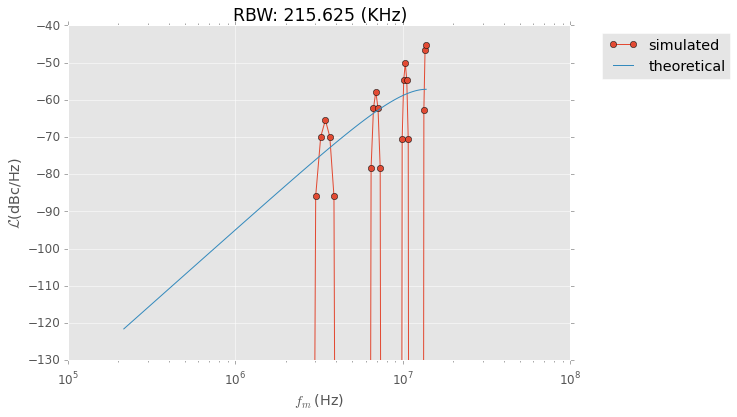

In [6]:
#Plot the power spectrum density
sim.plot('o-')
theory.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.title('RBW: {:2.3f} (KHz)'.format(rbw/1e3))
plt.ylim([-130,-40])
plt.grid(True)

The spurs appearance and amplitude depend both of the input word and the initial state of the registers of the modulator [3]. It can be that initializing the first register of the first register of the SDM creates enough dithering to reduce the spurs The gen_mash accepts a fourth argument to initialize the mash registers. This argument is a tuple with a number of elements that equals the order of the SDM.

Mean value of the sequence: 0.24999



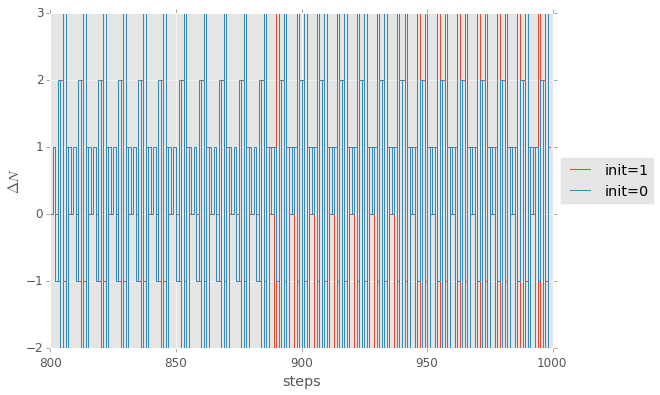

In [7]:
sd_init, per = sdmod.gen_mash(3,NsdBits,fracnum,(1,0,0))

# Calculate the phase error and its PSD
phi_div = 2*pi*(sd_init-fracnum[0]/2**NsdBits).cumsum()
f, Phi2_div = sig.welch(phi_div, fref, window="blackman", nperseg=npoints)
sim = pn.Pnoise(f[ind],10*log10(Phi2_div[ind]/2), label='simulated')

# plot the sequence
pltpoints = np.r_[800:1000]
plt.step(pltpoints,sd_init[pltpoints],label='init=1')
plt.step(pltpoints,sd[pltpoints], label='init=0')
plt.xlabel('steps') #x label
plt.ylabel('$\Delta N$') #y label
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
print("Mean value of the sequence: {:2.5f}\n".format(sd.mean()))

(-130, -40)

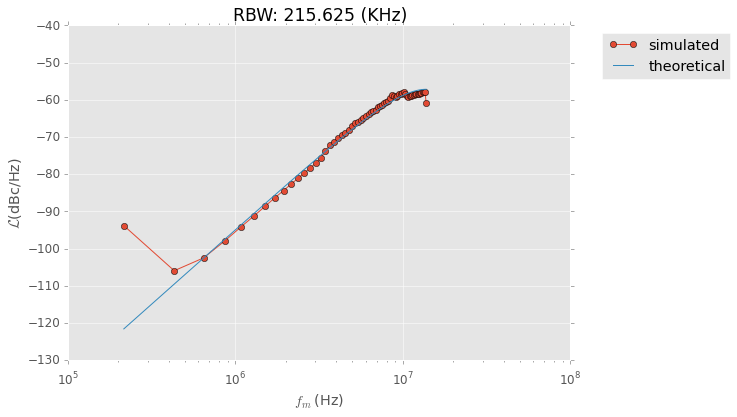

In [8]:
#Plot the power spectrum density
sim.plot('o-')
theory.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.title('RBW: {:2.3f} (KHz)'.format(rbw/1e3))
plt.ylim([-130,-40])

## Conclution

With this entry I revisited the theory of SD modulators using a module written in Python. The fundamental aspects of Mash SDM modulators are explained and documented. To analyse the output I used the nice Scipy library.  In this way, and with the help of the Ipython notebook, the linear theory of mash SDM and its limitations are well documented and results are easily replicated.

This shows what would be the intention with the plldesigner toolkit. This a project that I have been developing and aims to add specific functionality to the numpy+scipy+ipython ecosystem to simulate and model PLL's.

## References

1. B. Miller and R. J. Conley, “A multiple modulator fractional divider,” IEEE Transactions on Instrumentation and Measurement, vol. 40, no. 3, pp. 578–583, 1991.

2. T. A. D. Riley, M. A. Copeland, and T. A. Kwasniewski, “Delta-sigma modulation in fractional-N frequency synthesis,” IEEE Journal of Solid-State Circuits, vol. 28, no. 5, pp. 553–559, May 1993.

3. Kozak, M., Kale, I., "Rigorous analysis of delta-sigma modulators for fractional-N PLL frequency synthesis," IEEE Transactions on Circuits and Systems I: Regular Papers 51, 1148–1162, 2004. (doi:10.1109/TCSI.2004.829308)